plots on geocoronal Ha
LVM sky subtraction busyweek, Dec 2024
Kathryn Kreckel

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from astropy.io import fits, ascii

from astropy.wcs import wcs
from astropy.table import Table

from scipy.ndimage import median_filter
from astropy.modeling import models, fitting

from astropy.stats import mad_std

from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
from astropy.time import Time

from scipy.optimize import curve_fit


import matplotlib as mpl
import pickle

from astropy.table import QTable
from astropy import table

import glob
import os
import datetime 
import scipy 

import astral
from astropy.time import Time, TimezoneInfo
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astral.sun import sun
from datetime import date, time, timezone



from scipy.optimize import least_squares
from collections import Counter


#from shadow_height_lib import shadow_calc

In [2]:
font = {'size'   : 18}

mpl.rc('font', **font)

In [3]:
def forward(x):
    return x / 5.661e-18 # returns Rayleigh

def inverse(x):
    return x * 5.661e-18 # returns erg/s/cm^2/arcsec^2

Full fitting code is not shown, but available upon request. Resulting fits are compiled in the following fits file:


In [9]:
t0 = table.Table.read('saved_dictionary_geocoronal_v5.fits')  
drpall = table.Table.read('drpall-1.1.0.fits')

t0.sort('frame')


In [6]:
scl=24.

whams = table.unique(t, keys='wham')
syms=['1','3','4','^','|','<','.','2','>','o','X']
dd ={}

for i,w in enumerate(whams):
    dd[w['wham']] = syms[i]


In [7]:
# shadow height in the drpall file seems to be incorrect, 
# this code  fixes it but takes a little bit of time to run

if True:
    from shadow_height_lib import shadow_calc

    # initialize the shadow height calculation
    s=shadow_calc()

    for dd in drpall:
        time = Time(dd['obstime'],format='isot', scale='utc')
        jj = time.jd

        cc = SkyCoord(dd['skye_ra'],dd['skye_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skye_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['skyw_ra'],dd['skyw_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skyw_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['sci_ra'],dd['sci_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['sci_sh_hght'] = s.get_heights(return_heights=True, unit="km")



/Users/kreckel/research/SDSSV/projects/sky_sub/geocoronal_figs/v1.1.0/shadow_height_lib.py:172: RuntimeWarning: All-NaN axis encountered
  self.dist[positive_delta] = np.nanmin([dist_b1[positive_delta], dist_b2[positive_delta]], axis=0)


**Columns in the astropy table based on the geocoronal line fits:**

* 'frame': exposure number
* 'mjd': MJD
* 'wham': name of the WHAM dark field
* 'center': geocoronal ha line centroid (A)
* 'flux': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'flux_err': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'stddev': geocoronal ha line broadening
* 'center6533': OH 6533 line centroid (A)
* 'flux6533': OH 6553 line flux (erg/s/cm^2/arcsec^2)
* 'center6554': OH 6554 line centroid (A)
* 'flux6554': OH 6554 line flux (erg/s/cm^2/arcsec^2)
* 'am': airmass
* 'hz': shadow height (km)
* 'filename': filename
* 'sky': which sky telescope
* 'baseline': median continuum level of sky spectrum (erg/s/cm^2/A/Fiber)
* 'rho': separation of Moon and object (deg)
* 'sun_alt': sun altitude (deg)
* 'time': time as astropy.time object
* 'solar_obsflux': Daily flux values are the radio emission from the Sun at a wavelength of 10.7 centimetres recorded daily (sfu = solar flux unit).
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-3-en.php

In [332]:
# Define the model
# tau is fixed across all data, r0 and rbgr are fixed per night
def model(params, x, nights):
    tau = params[0]  # First parameter is tau
    r0 = params[1:len(np.unique(nights)) + 1]  # Normalization for each night
    rbgr = params[len(np.unique(nights)) + 1:]  # Background for each night
    # Calculate the exponential function for each night
    return r0[nights.astype(int)] * np.exp(-x / tau) + rbgr[nights.astype(int)]

# Define the residual function
def residuals(params, x, y, nights):
    return model(params, x, nights) - y



In [376]:

# organize the data
tt = t0['time'].data[:,1]*24
tt[tt > 0] -= 24
        

sunset = (tt < -8)
midnight = (tt <= -5) & (tt >= -8)
dawn = (tt > -5)

sections = [sunset, midnight, dawn]
titles = ['start (t <-8h)','middle (-8 < t < -5)','end (-5 < t) ']

    

Fitted scale length (tau): 2.132129412882758
Fitted normalization (r0): [  4.23468374   5.36339931   5.88599485   8.33306074   7.06811566
  10.71577944   6.31304592   4.92128274   9.22352327   6.34335072
   6.29711513   5.52209527   6.86283517   5.42265152   7.08654852
   6.4168685    6.93814275   5.07068588   6.5506839    3.41149602
   5.00456853   4.72407862   2.32478072  10.36842006   8.11987205
   7.16811666   9.08474927   7.43986403   7.55606135   7.70899392
   9.67398521   8.25977659   7.40036347   7.13977124   4.9409773
   7.52880376   7.07329668   5.85436226   5.98214758   5.76528688
  23.43426606   3.79741476   9.443888     6.55883235   6.05400411
  10.76939525   6.74120674   9.0876831  270.02807233 149.51720071
  26.87038871  19.97150142  14.87107426  12.68206819   9.43513024
   8.71062608   8.07659189   7.11256965   6.97943484   6.28393419
   6.72301042   7.26517898   7.39868063   7.40001342   6.60938589
   6.82447232   6.54489724   6.7933487    6.74931965   6.73915962
   6.

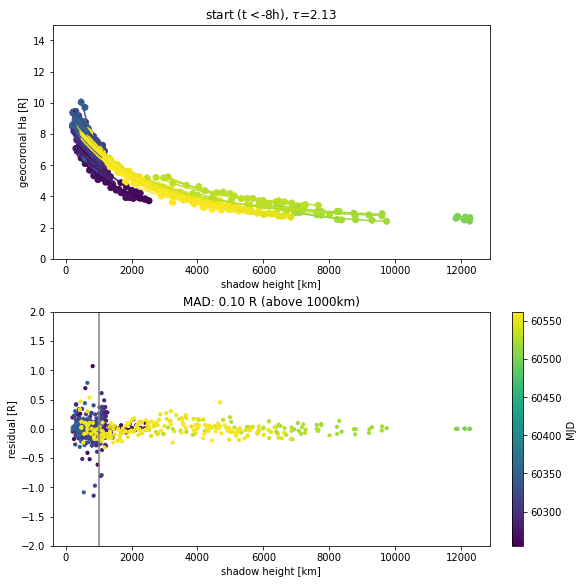

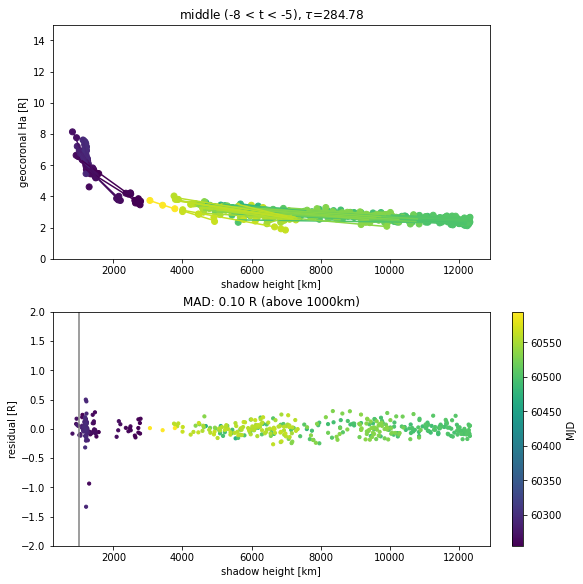

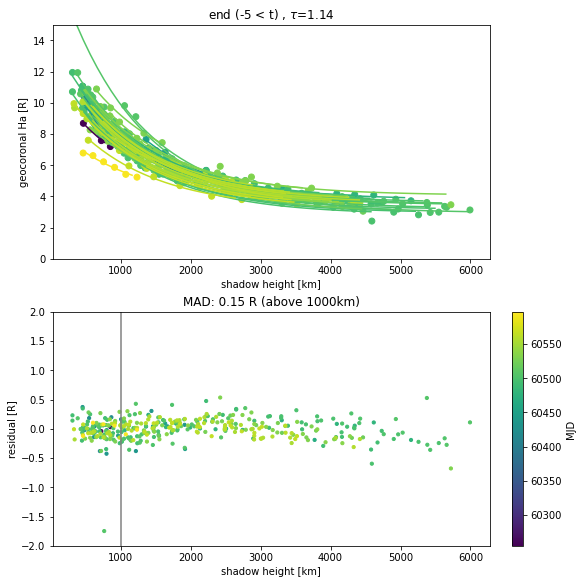

In [377]:
# fit each night with a function where the tau are tied, but r0 and r_bgr are only fit to individual half-nights
# exclude WHAM_south_08 and use only low airmass < 1.1 & no moon

dd = {}
for ii,ss in enumerate(sections):
    # low airmass
    # no cloud issues, based on sky continuum
    #low errors on the geocoronal line fit
     # things at very high shadowheight behave oddly
        # not this WHAM field
         # first half of the night
    iis0 =  (t0['am'] < 1.2) & \
            (t0['baseline'] < 7e-15) & (t0['baseline'] > 1e-15) & \
            (forward(t0['flux_err']) < 0.4) & \
            (t0['hz'] < 15000) & \
            ss #& (tt < -5)
    #        (t0['wham'] != 'WHAM_south_08') & \

    t = t0[iis0]

    # Count the number of measurements for each unique night
    night_counts = Counter(t['mjd'])

    # Create a boolean array: True if a night has more than 5 measurements, otherwise False
    night_has_more_than_5 = np.array([night_counts[n] > 2 for n in t['mjd']])

    #(t['moon_alt'] < 0) & 
    # & (t['wham'] != 'WHAM_south_08')
    iis =  night_has_more_than_5 #& (t['wham'] != 'WHAM_south_08') # first half of the night
    sub = t[iis]

    # Normalize the array vals so they can be mapped to a color
    #c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
    c_norm = mpl.colors.Normalize(vmin=np.min(t['mjd']), vmax=np.max(t['mjd']))

    # Pick a colormap
    c_map  = mpl.cm.viridis

    # Scalar mappable of normalized array to colormap
    s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
    s_map.set_array([])


    fig,axes = plt.subplots(2,1,layout='constrained', figsize=(8, 8))

    x_all = sub['hz'].data/1000.

    tau=0.14
    scl2 = np.exp(-1.*tau*(sub['am'].data-1))
    y_all = forward(sub['flux'].data*scl2) 
    y_res = y_all * np.nan

    nights = sub['mjd'].data

    # Step 1: Get the unique values of nights
    unique_nights = np.unique(nights)

    # Step 2: Create a mapping from unique values to integers
    night_to_index = {night: idx for idx, night in enumerate(unique_nights)}

    # Step 3: Map the original nights array to indices
    nights_indices = np.array([night_to_index[night] for night in nights])


    # Initial guesses
    tau_initial = 3.0  # Fixed scale length
    num_nights = len(np.unique(nights))
    initial_r0 = np.ones(num_nights) * 5  # Initial guess for r0
    initial_rbgr = np.zeros(num_nights)  # Initial guess for background
    initial_params = np.concatenate([[tau_initial], initial_r0, initial_rbgr])

    # Fit the data
    result = least_squares(residuals, initial_params, args=(x_all, y_all, nights_indices))

    # Extract fitted parameters
    fitted_tau = result.x[0]
    fitted_r0 = result.x[1:num_nights+1]
    fitted_rbgr = result.x[num_nights+1:]

    # Print results
    print(f"Fitted scale length (tau): {fitted_tau}")
    print(f"Fitted normalization (r0): {fitted_r0}")
    print(f"Fitted background (rbgr): {fitted_rbgr}")

    # Plot data and fit
    for i, night in enumerate(np.unique(nights)):
        mask = (nights == night)
        axes[0].scatter(x_all[mask]*1000, y_all[mask], label=f"Night {int(night) + 1}",c=s_map.to_rgba(nights[mask]))
        ex = np.arange(np.min(x_all[mask]),np.max(x_all[mask]),.1)
        axes[0].plot(ex*1000, fitted_r0[i] * np.exp(-1.*ex / fitted_tau) + fitted_rbgr[i],
                 label=f"Fit Night {int(night) + 1}",color=s_map.to_rgba(np.median(nights[mask])))
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[1].scatter(x_all[mask]*1000., y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c =s_map.to_rgba(nights[mask]),s=10 )

    axes[1].axvline(1000,color='grey')       

    axes[0].set_title(titles[ii]+fr', $\tau$={fitted_tau:.2f}')
    stat_mad = mad_std(y_res[x_all > 1])
    axes[1].set_title(f'MAD: {stat_mad:.2f} R (above 1000km)')

    axes[0].set_xlabel("shadow height [km]")
    axes[0].set_ylabel("geocoronal Ha [R]")
    axes[1].set_xlabel("shadow height [km]")
    axes[1].set_ylabel("residual [R]")
    #axes[0].set_xlim(0,10000)
    axes[0].set_ylim(0,15)
    #axes[1].set_xlim(0,10000)
    axes[1].set_ylim(-2,2)

    plt.colorbar(s_map, label=r'MJD')
    plt.savefig(f'fitnight_{ii}.png')

    dd[ii] = {'nights':nights, 'fitted_tau':fitted_tau, 'fitted_r0':fitted_r0, 'fitted_rbgr':fitted_rbgr ,'section':ss,'title':titles[ii]}

        

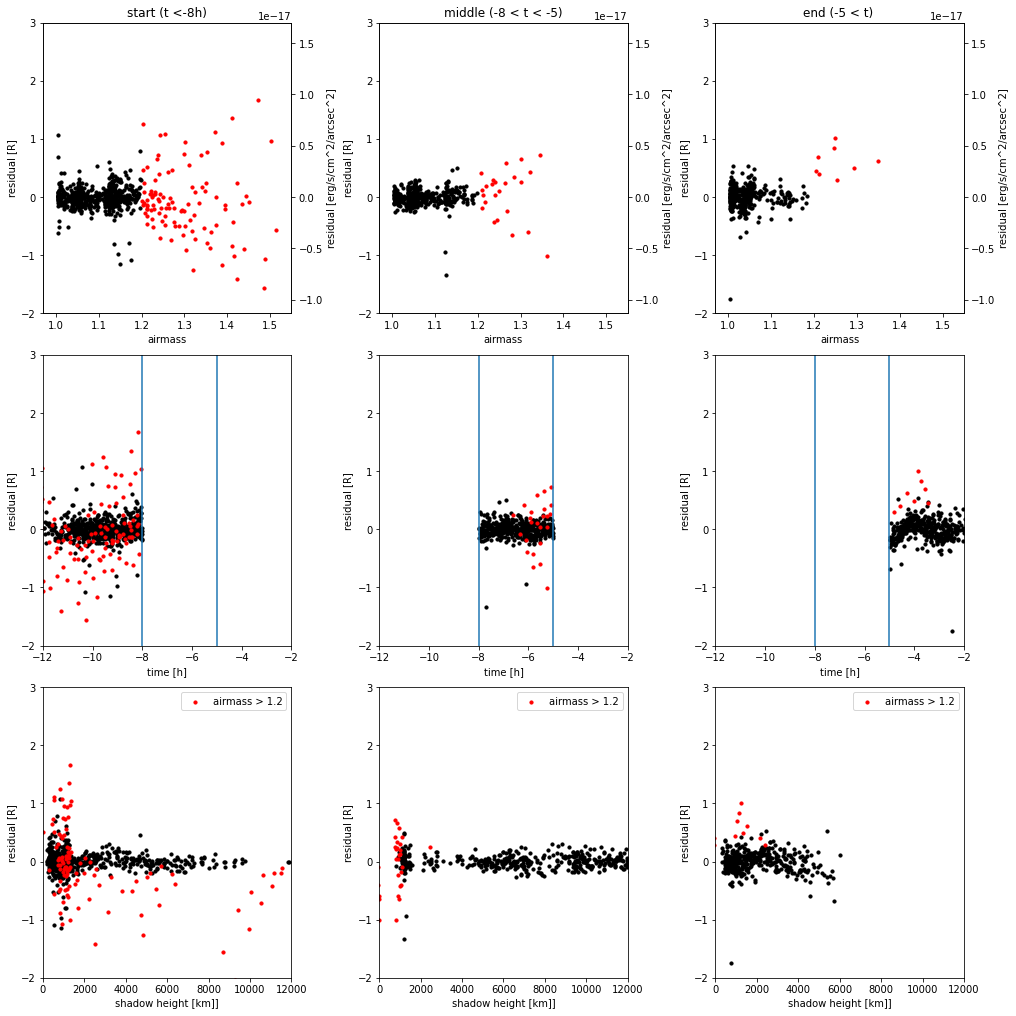

In [378]:
fig,axes = plt.subplots(3,3,layout='constrained', figsize=(14, 14))

for part in dd:
    nights = dd[part]['nights']
    fitted_tau = dd[part]['fitted_tau']
    fitted_r0 = dd[part]['fitted_r0']
    fitted_rbgr = dd[part]['fitted_rbgr']
    ss = dd[part]['section']    

    tt = t0['time'].data[:,1]*24
    tt[tt > 0] -= 24
    nn_bool =  [nn in np.unique(nights) for nn in t0['mjd']]
    nightsU =  np.unique(nights)

    iis0 =  (t0['baseline'] < 7e-15) & (t0['baseline'] > 1e-15) & (forward(t0['flux_err']) < 0.4) & \
            (t0['hz'] < 15000) &  nn_bool & ss & (t0['am'] < 1.2)


    sub2 = t0[iis0]
    x_all = sub2['hz'].data/1000.
    tau=0.14
    scl2 = np.exp(-1.*tau*(sub2['am'].data-1))
    y_all = forward(sub2['flux'].data*scl2) 
    y_res = y_all * np.nan
    am = sub2['am'].data
    nights2 = sub2['mjd'].data
    az = sub2['wham_az'].data
    timey2 = tt[iis0]
    ff6554 = forward(sub2['flux6554'].data*scl2)
    sun_alt = sub2['sun_alt'].data

    for night in (np.unique(nights2)):
        mask = (nights2 == night)
        i = np.where(night == nightsU)
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[0,part].scatter(am[mask], y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='k',s=10 )
    axes[0,part].set_xlabel("airmass")

    for night in (np.unique(nights2)):
        mask = (nights2 == night)
        i = np.where(night == nightsU)
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[1,part].scatter(timey2[mask], y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='k',s=10 )
    axes[1,part].set_xlabel("time [h]")


    for night in (np.unique(nights2)):
        mask = (nights2 == night)
        i = np.where(night == nightsU)
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[2,part].scatter(x_all[mask]*1000, y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='k',s=10 )
    axes[2,part].set_xlabel("shadow height [km]]")


    for ax in axes[:,part]:
        ax.set_ylim(-2,3)
        ax.set_ylabel("residual [R]")

    ax2 = axes[0,part].twinx()
    lim1,lim2 = axes[0,part].get_ylim()
    ax2.set_ylim(inverse(lim1),inverse(lim2))
    ax2.set_ylabel(r'residual [erg/s/cm^2/arcsec^2]')

    #    ax.set_ylim(inverse(-2),inverse(3))
    #    ax.set_ylabel("residual [erg/s/cm^2/arcsec^2]")


    # higher airmass
    iis08 =  (t0['baseline'] < 7e-15) & (t0['baseline'] > 1e-15) & (forward(t0['flux_err']) < 0.4) & \
            (t0['hz'] < 15000) &  nn_bool & (t0['am'] > 1.2) &  ss


    sub2 = t0[iis08]
    x_all = sub2['hz'].data/1000.
    tau=0.14
    scl2 = np.exp(-1.*tau*(sub2['am'].data-1))
    y_all = forward(sub2['flux'].data*scl2) 
    y_res = y_all * np.nan
    am = sub2['am'].data
    nights2 = sub2['mjd'].data
    az = sub2['wham_az'].data
    timey2 = tt[iis08]
    ff6554 = forward(sub2['flux6554'].data*scl2)
    sun_alt = sub2['sun_alt'].data


    for night in (np.unique(nights2)):
        mask = (nights2 == night)
        i = np.where(night == nightsU)
        y_res[mask] = y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i])
        axes[0,part].scatter(am[mask], y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='r',s=10 )

        axes[1,part].scatter(timey2[mask], y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='r',s=10 )
        axes[2,part].scatter(x_all[mask]*1000, y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='r',s=10 )
    axes[2,part].scatter(sun_alt[mask], y_all[mask] - (fitted_r0[i] * np.exp(-x_all[mask] / fitted_tau) + fitted_rbgr[i]),c ='r',s=10 ,label='airmass > 1.2')

    axes[0,part].set_title(titles[part])
    axes[1,part].axvline(-8)
    axes[1,part].axvline(-5)
    axes[0,part].set_xlim(0.97,1.55)
    axes[1,part].set_xlim(-12,-2)
    axes[2,part].set_xlim(0,12000)

    axes[2,part].legend()
    
plt.savefig('fitnight_residuals.png')

Text(0.5, 0, 'MJD')

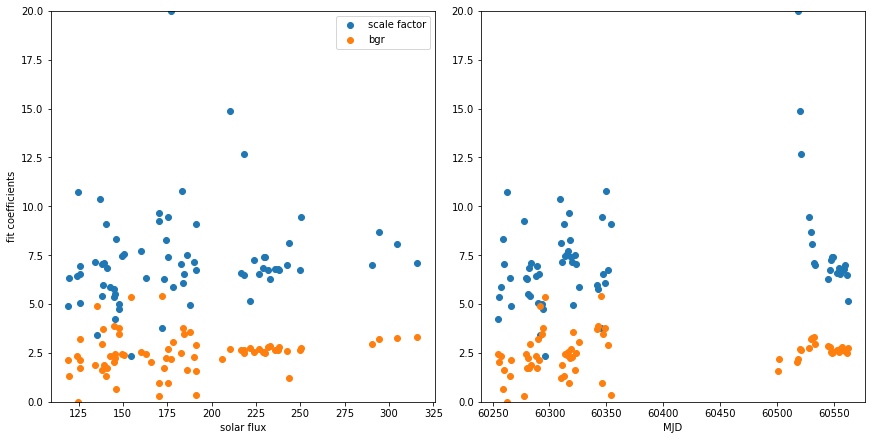

In [306]:
#print(len(unique_nights),len(fitted_r0), len(fitted_rbgr))

sol = []
for u in unique_nights:
    tmp = (t['mjd']==u)
    sol.append(t['solar_obsflux'][tmp][0])

fig,axes = plt.subplots(1,2,layout='constrained', figsize=(12, 6))

axes[0].scatter(sol,fitted_r0,label='scale factor')
#plt.ylim(-50,50)

axes[0].scatter(sol,fitted_rbgr,label='bgr')
axes[0].set_ylim(0,20)

axes[0].set_xlabel('solar flux')
axes[0].set_ylabel('fit coefficients')

axes[0].legend()

axes[1].scatter(unique_nights,fitted_r0,label='scale factor')
axes[1].scatter(unique_nights,fitted_rbgr,label='bgr')
axes[1].set_ylim(0,20)
axes[1].set_xlabel('MJD')
